In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage import data, exposure
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn import svm

from time import time
from matplotlib import offsetbox
from sklearn import manifold

## Loading data

In [2]:
# data-loading
images = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/data/images.npy')
labels = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/data/labels.npy')

## Creating binary images by applying adaptive thresholding

In [3]:
#binary images
from skimage.filters import threshold_local
thresh_images = np.zeros(images.shape, dtype='uint')


for i in range(len(thresh_images)):
    
    threshed = np.zeros((28, 28), dtype='uint')
    im = images[i, :, :]
    
    
    threshed[im<80] = 1
    threshed[im>80] = 0
    
    thresh_images[i, :, :] = threshed
    
     

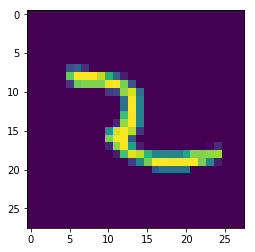

In [4]:
plt.imshow(images[558, :, :])

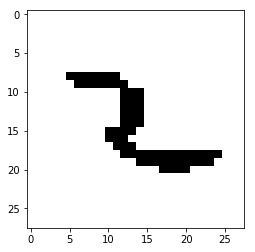

In [5]:
plt.imshow(thresh_images[558,:,:], cmap='gray')

## Creating HOG feature vector for dimentionality reduction

In [12]:
hog_results = np.zeros((392, 60000), dtype='float64')
for i in range(60000):
    hog_results[:, i] = hog(thresh_images[i, :, :], orientations=8, pixels_per_cell=(4, 4),
                            cells_per_block=(1, 1), visualize=False, multichannel=False)


/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


## To visualize our high-dimentional HOG matrix, lets use t-distributed Stochastic Neighbor Embedding

In [ ]:
X = np.transpose(hog_results)
y = labels
n_samples, n_features = X.shape
n_neighbors = 30

In [ ]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(hog_results[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [ ]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, perplexity=50,early_exaggeration = 4.0, n_iter = 250, init='pca', random_state=0)

X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)

plt.show()
np.save('./X_tsne.npy',X_tsne)

## PCA 

In [14]:
#apply PCA to reduce dimentionality 
X = np.transpose(hog_results)
y = labels

pca = PCA(n_components = 16, svd_solver='full')
a = pca.fit_transform(X)


## Next step is to implement SVM to train our model

In [20]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(a, y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
dec = clf.decision_function(a)

In [29]:
clf.decision_function_shape = "ovr"